# 경사 하강법(GD), 확률적 경사 하강법(SGD) 경사 하강법 비교

송준

고려대학교 통계학과

## 1. 필요한 라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# seed 설정
torch.manual_seed(42)
np.random.seed(42)

## 2. 1차원 선형 회귀 예제 (시각화 중심)

### 2.1 데이터 생성 및 시각화


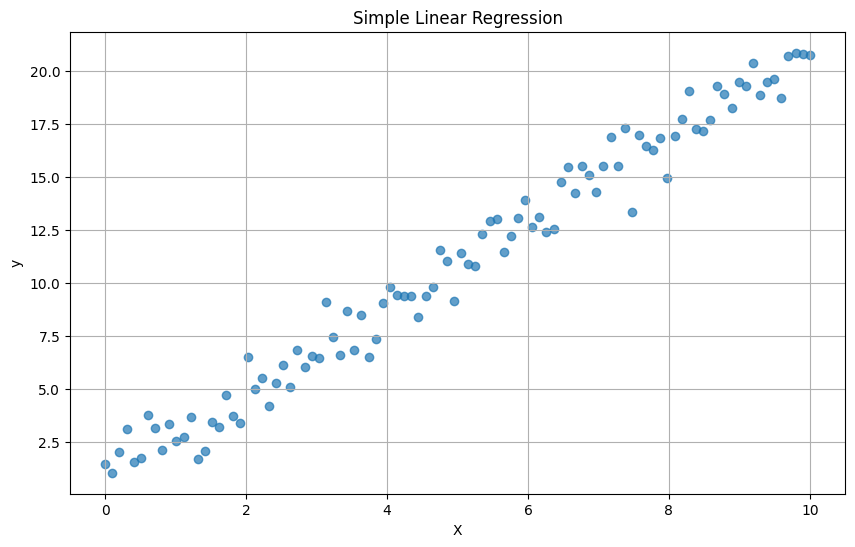

In [2]:
# 데이터 생성
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 2 * X + 1 + 0.5 * np.random.randn(100, 1) * 2  # y = 2x + 1 + 노이즈

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7)
plt.title("Simple Linear Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.show()

# %%
# PyTorch 텐서로 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

### 2.2 모델 정의

In [3]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)

### 2.3 학습 함수 정의

In [4]:
def train_model(optimizer_type, data_loader, epochs=100, lr=0.01):
    # 모델 초기화
    model = LinearRegression(input_dim=1)
    criterion = nn.MSELoss()
    
    # 옵티마이저 선택
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_type == 'GD':
        optimizer = optim.SGD(model.parameters(), lr=lr)  # GD는 배치 크기가 전체 데이터
    else:  # 미니배치
        optimizer = optim.SGD(model.parameters(), lr=lr)
    
    losses = []
    weights = []
    biases = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in data_loader:
            # 순전파
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # epoch당 평균 손실 저장
        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)
        
        # 가중치 추적
        weights.append(model.linear.weight.item())
        biases.append(model.linear.bias.item())
        
        if (epoch+1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return model, losses, weights, biases

### 2.4 데이터 로더 설정 (GD, SGD, 미니배치)

In [5]:
# GD (전체 배치)
gd_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=len(X_tensor), shuffle=False)

# SGD (배치 크기 1)
sgd_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=1, shuffle=True)

# SGD2-미니배치 (배치 크기 16)
minibatch_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)


### 2.5 모델 학습 및 결과 비교

In [6]:
# 각 방법별로 모델 학습
gd_model, gd_losses, gd_weights, gd_biases = train_model('GD', gd_loader, epochs=40, lr=0.01)
sgd_model, sgd_losses, sgd_weights, sgd_biases = train_model('SGD', sgd_loader, epochs=40, lr=0.01)
minibatch_model, minibatch_losses, minibatch_weights, minibatch_biases = train_model('Minibatch', minibatch_loader, epochs=40, lr=0.01)


Epoch [20/40], Loss: 0.8222
Epoch [40/40], Loss: 0.8209
Epoch [20/40], Loss: 1.4127
Epoch [40/40], Loss: 1.5570
Epoch [20/40], Loss: 0.8663
Epoch [40/40], Loss: 0.8014


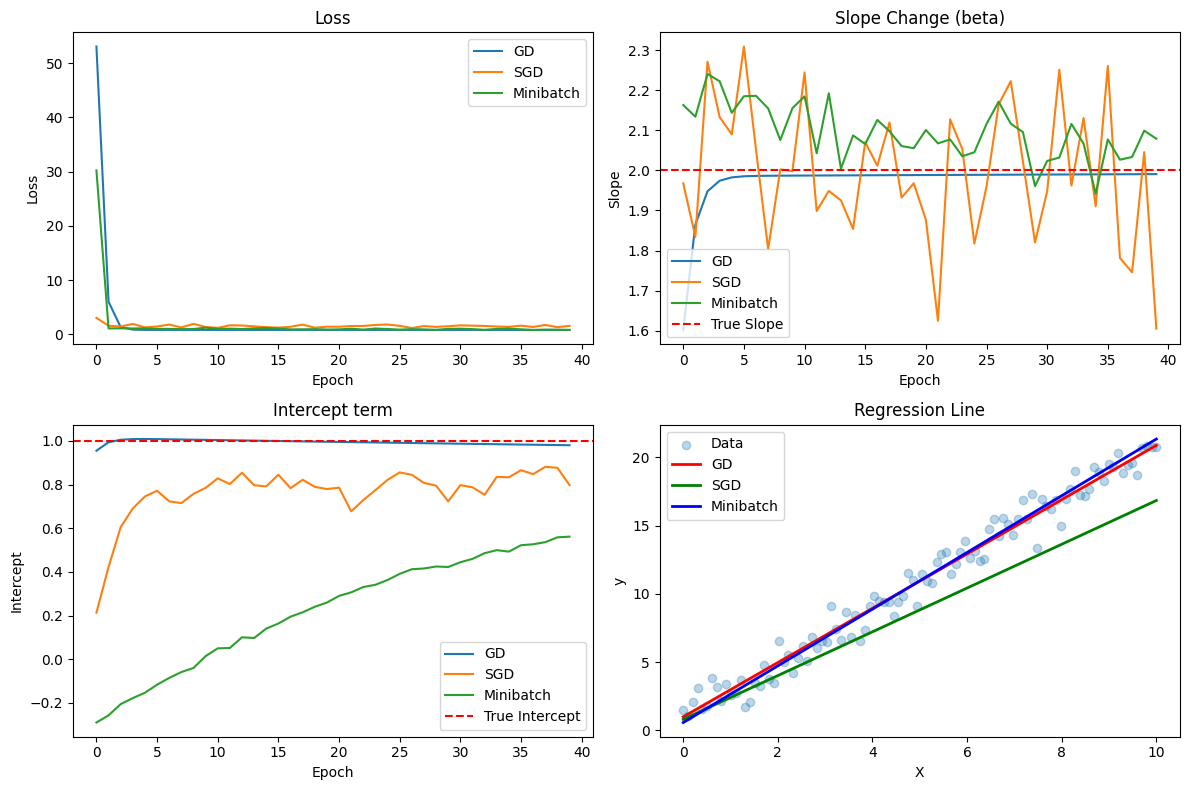

In [7]:
# 손실 곡선 비교
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(gd_losses, label='GD')
plt.plot(sgd_losses, label='SGD')
plt.plot(minibatch_losses, label='Minibatch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Slope 변화
plt.subplot(2, 2, 2)
plt.plot(gd_weights, label='GD')
plt.plot(sgd_weights, label='SGD')
plt.plot(minibatch_weights, label='Minibatch')
plt.axhline(y=2.0, color='r', linestyle='--', label='True Slope')
plt.title('Slope Change (beta)')
plt.xlabel('Epoch')
plt.ylabel('Slope')
plt.legend()

# Intercept 변화
plt.subplot(2, 2, 3)
plt.plot(gd_biases, label='GD')
plt.plot(sgd_biases, label='SGD')
plt.plot(minibatch_biases, label='Minibatch')
plt.axhline(y=1.0, color='r', linestyle='--', label='True Intercept')
plt.title('Intercept term')
plt.xlabel('Epoch')
plt.ylabel('Intercept')
plt.legend()


# Regression Line 비교
plt.subplot(2, 2, 4)
plt.scatter(X, y, alpha=0.3, label='Data')
plt.plot(X, gd_model(X_tensor).detach().numpy(), 'r-', linewidth=2, label='GD')
plt.plot(X, sgd_model(X_tensor).detach().numpy(), 'g-', linewidth=2, label='SGD')
plt.plot(X, minibatch_model(X_tensor).detach().numpy(), 'b-', linewidth=2, label='Minibatch')
plt.title('Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

**손실 곡선 비교:**
- GD: 부드럽게 감소하지만 느리게 수렴
- SGD (batch=1): 진동이 심하지만 빠르게 감소
- SGD (batch=16): GD보다 빠르고 SGD보다 안정적

**Parameter 수렴:**
- GD: 안정적으로 수렴
- SGD: 큰 폭으로 진동하면서 접근
- SGD (batch=16): 진동이 있으나 비교적 안정적으로 접근

**경사 하강법(GD):**
- 전체 데이터셋을 사용해 한 번에 그래디언트 계산
- 정확하지만 계산 비용이 높음
- 대규모 데이터에 비효율적

**확률적 경사 하강법(SGD):**
- 무작위로 선택한 샘플로 그래디언트 계산
- 빠르지만 노이즈가 많음
- 지역 최적점 탈출에 유리

## 3. 다차원 선형 회귀 예제 (5차원)

### 3.1 데이터 생성 및 데이터 로더 설정

In [8]:
# 5차원 회귀 데이터 생성
X, y, coef = make_regression(n_samples=1000, n_features=5, noise=0.1, coef = True, random_state=0)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 텐서 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# %% [markdown]
# ### 3.2 데이터 로더 설정

# %%
# GD (전체 배치)
gd_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                      batch_size=len(X_train_tensor), shuffle=False)

# 미니배치 (배치 크기 32)
minibatch_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                             batch_size=32, shuffle=True)

### 3.2 모델 학습

In [9]:
def train_multi_model(data_loader, epochs=100, lr=0.01):
    model = LinearRegression(input_dim=5)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    # 테스트 성능 평가
    with torch.no_grad():
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor).item()
        print(f'Test Loss: {test_loss:.4f}')
    
    return model, losses

In [10]:
# GD 학습
print("GD 학습 결과:")
gd_model, gd_losses = train_multi_model(gd_loader, epochs=50, lr=0.1)

# 미니배치 학습
print("\n미니배치 학습 결과:")
minibatch_model, minibatch_losses = train_multi_model(minibatch_loader, epochs=50, lr=0.01)


GD 학습 결과:
Epoch [10/50], Loss: 193.5998
Epoch [20/50], Loss: 2.7440
Epoch [30/50], Loss: 0.0512
Epoch [40/50], Loss: 0.0109
Epoch [50/50], Loss: 0.0103
Test Loss: 0.0095

미니배치 학습 결과:
Epoch [10/50], Loss: 0.9579
Epoch [20/50], Loss: 0.0103
Epoch [30/50], Loss: 0.0103
Epoch [40/50], Loss: 0.0103
Epoch [50/50], Loss: 0.0103
Test Loss: 0.0096


### 3.3 학습 결과 비교

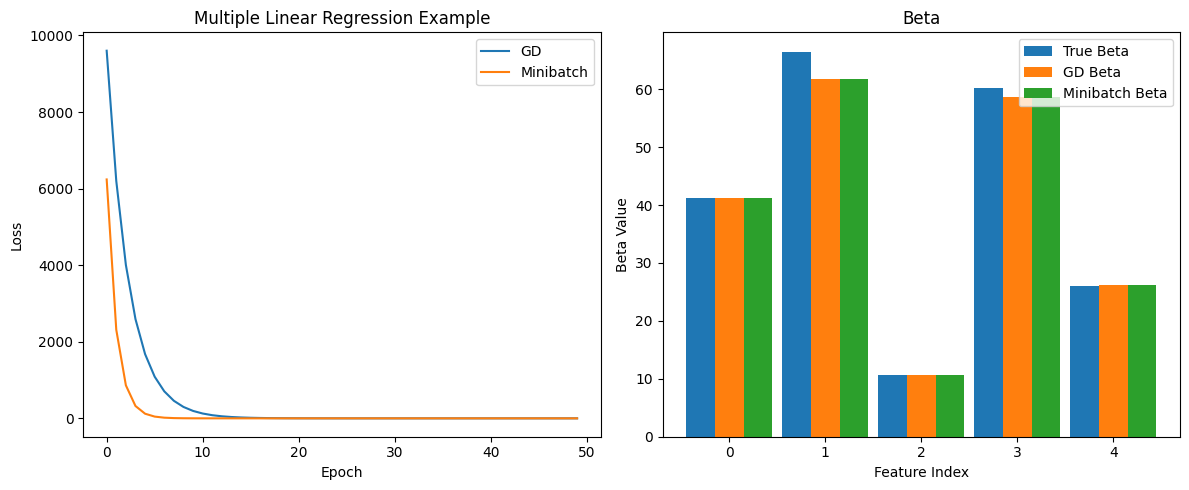

In [11]:
# 손실 곡선 비교
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gd_losses, label='GD')
plt.plot(minibatch_losses, label='Minibatch')
plt.title('Multiple Linear Regression Example')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# beta 비교
true_beta = coef  # make_regression의 true beta

plt.subplot(1, 2, 2)
gd_beta = gd_model.linear.weight.detach().numpy().flatten()
minibatch_beta = minibatch_model.linear.weight.detach().numpy().flatten()

x = np.arange(len(true_beta))
width = 0.3

plt.bar(x - width, true_beta, width, label='True Beta')
plt.bar(x, gd_beta, width, label='GD Beta')
plt.bar(x + width, minibatch_beta, width, label='Minibatch Beta')
plt.xlabel('Feature Index')
plt.ylabel('Beta Value')
plt.title('Beta')
plt.legend()

plt.tight_layout()
plt.show()


# 개념: GD vs SGD에서의 Epoch과 Iteration 차이

두 방법을 비교할 때는 epoch과 iteration 개념을 명확히 이해해야 합니다.

- Epoch(에폭): 전체 데이터를 한 번 모두 사용했을 때를 1 epoch이라고 합니다.
- Iteration(반복): 파라미터가 업데이트되는 횟수를 의미합니다.
    - Batch GD: 1 epoch 당 1 iteration
    - SGD: 1 epoch 당 데이터의 수만큼 iteration (batch_size=1의 경우)

즉, 각 에폭당 iteration 수는 다음과 같습니다.

| 방법  | Epoch당 Iteration 수 (예제에서) |
| --- | ------------------------- |
| GD  | 1 (전체 데이터를 한 번에 사용)       |
| SGD | 100 (데이터가 100개일 때)        |


In [ ]:
# GD
for epoch in range(100):
    # 전체 데이터로 1번 업데이트 (iteration=1)

# SGD
for epoch in range(10):
    for xi, yi in loader: # iteration=100
        # 개별 데이터마다 100번 업데이트

이 설정을 iteration 수로 다시 환산하면 다음과 같습니다.

- GD: 100 epochs X 1 = 100 iterations
- SGD: 10 epochs X 100 = 1000 iterations

즉, 위의 예제에서는 GD가 실제 파라미터를 업데이트한 횟수(=iteration)는 100번인데,
SGD는 iteration이 1000번으로 더 많습니다.